In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/HAPT Data Set"

Mounted at /content/drive
/content/drive/MyDrive/HAPT Data Set


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow.keras as kr
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Flatten, Dropout, LSTM, Bidirectional, TimeDistributed, ConvLSTM2D
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, OneHotEncoder
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
files = os.listdir('./RawData/')
raw_labels = pd.read_csv('RawData/labels.txt',sep=' ',header=None)
raw_labels['diff'] = raw_labels[4] - raw_labels[3]
intervals = raw_labels['diff']

In [ ]:
files.sort()
#files

In [ ]:
acc_file = []
gyro_file = []
for file in files:
    if file.startswith('acc'):
        acc_file.append(pd.read_csv('RawData/' + file, sep=' ', header=None))
    elif file.startswith('gyro'):
        gyro_file.append(pd.read_csv('RawData/' + file, sep=' ', header=None))


In [ ]:
columns = ['user', 'activity', 'time', 'ax','ay','az', 'gx', 'gy', 'gz', 'interval']
label_dict = {1: "WALKING",
              2: "WALKING_UPSTAIRS",
              3: "WALKING_DOWNSTAIRS",
              4: "SITTING",
              5: "STANDING",
              6: "LAYING",
              7: "STAND_TO_SIT",
              8: "SIT_TO_STAND", 
              9: "SIT_TO_LIE", 
              10: "LIE_TO_SIT",
              11: "STAND_TO_LIE",
              12: "LIE_TO_STAND"}
label_dict_rev = {v: k for k, v in label_dict.items()}
label_list = list(label_dict.values())

In [ ]:
data = []
for exper, user, label, start, end, itv in raw_labels.values:
    temp = [user, label_dict[label]]
    for i in range(end-start):
        #print(exper,user,label_dict[label])
        a = acc_file[exper-1].values[start+i-1]
        b = gyro_file[exper-1].values[start+i-1]
        temp.append(start+i-1)
        temp.extend([a[0], a[1], a[2]])
        temp.extend([b[0], b[1], b[2]])
        temp.append(itv)
        data.append(temp)
        temp = [user, label_dict[label]]

In [ ]:
data = pd.DataFrame(data = data, columns = columns)

In [ ]:
data.head()

,user,activity,time,ax,ay,az,gx,gy,gz,interval
0,1,STANDING,249,1.020833,-0.125,0.104167,-0.000916,0.001833,0.002749,982
1,1,STANDING,250,1.020833,-0.125,0.105556,-0.002749,-0.004276,0.002749,982
2,1,STANDING,251,1.025000,-0.125,0.101389,-0.000305,-0.002138,0.006109,982
3,1,STANDING,252,1.020833,-0.125,0.104167,0.012217,0.000916,-0.007330,982
4,1,STANDING,253,1.016667,-0.125,0.108333,0.011301,-0.001833,-0.006414,982


In [ ]:
subject_id_train = pd.read_csv('subject_id_train.txt',header=None)[0].unique()
subject_id_test = pd.read_csv('subject_id_test.txt',header=None)[0].unique()

In [ ]:
train = data[data.user.isin(subject_id_train)]
test = data[data.user.isin(subject_id_test)]

In [ ]:
train = train.drop(['user','time','interval'],axis=1).copy()
test = test.drop(['user','time','interval'],axis=1).copy()

In [ ]:
train['activity'] = train['activity'].map(label_dict_rev)
test['activity'] = test['activity'].map(label_dict_rev)

In [ ]:
x_train = train.drop('activity',axis=1)
y_train = train['activity']
x_test = test.drop('activity',axis=1)
y_test = test['activity']

In [ ]:
x_train

,ax,ay,az,gx,gy,gz
0,1.020833,-0.125000,0.104167,-0.000916,0.001833,0.002749
1,1.020833,-0.125000,0.105556,-0.002749,-0.004276,0.002749
2,1.025000,-0.125000,0.101389,-0.000305,-0.002138,0.006109
3,1.020833,-0.125000,0.104167,0.012217,0.000916,-0.007330
4,1.016667,-0.125000,0.108333,0.011301,-0.001833,-0.006414
...,...,...,...,...,...,...
814395,0.987500,-0.495833,-0.197222,1.129184,1.006095,-0.224798
814396,0.950000,-0.443056,-0.187500,1.184773,1.112386,-0.307876
814397,0.880556,-0.390278,-0.156944,1.163698,1.106277,-0.374155
814398,0.834722,-0.358333,-0.098611,1.177137,1.023810,-0.388816


In [ ]:
## Use StandardScaler instead
scale_columns = list(x_train.columns)
scaler = StandardScaler()
scaler = scaler.fit(x_train[scale_columns])
x_train.loc[:,scale_columns] = scaler.transform(
    x_train[scale_columns].to_numpy()
)
x_test.loc[:,scale_columns] = scaler.transform(
    x_test[scale_columns].to_numpy()
)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
random_seed = 3244
n_time_steps = 250
n_features = 6
step = 50
n_classes = 12
n_epochs = 50
batch_size = 64
learning_rate = 0.001
l2_loss = 0.0015

In [ ]:
segments = []
labels = []
for i in range(0,x_train.shape[0]-n_time_steps,step):
  axs = x_train['ax'].values[i:i+n_time_steps]
  ays = x_train['ay'].values[i:i+n_time_steps]
  azs = x_train['az'].values[i:i+n_time_steps]
  gxs = x_train['gx'].values[i:i+n_time_steps]
  gys = x_train['gy'].values[i:i+n_time_steps]
  gzs = x_train['gz'].values[i:i+n_time_steps]
  label = stats.mode(train['activity'][i:i+n_time_steps])[0][0]
  segments.append([axs,ays,azs,gxs,gys,gzs])
  labels.append(label)

x_train_segments = np.asarray(segments,dtype=np.float32).reshape(-1,n_time_steps,n_features)
labels = np.asarray(pd.get_dummies(labels),dtype=np.float32)

In [ ]:
test_segments = []
test_labels = []
for i in range(0,x_test.shape[0]-n_time_steps,step):
  axs = x_test['ax'].values[i:i+n_time_steps]
  ays = x_test['ay'].values[i:i+n_time_steps]
  azs = x_test['az'].values[i:i+n_time_steps]
  gxs = x_test['gx'].values[i:i+n_time_steps]
  gys = x_test['gy'].values[i:i+n_time_steps]
  gzs = x_test['gz'].values[i:i+n_time_steps]
  label = stats.mode(test['activity'][i:i+n_time_steps])[0][0]
  test_segments.append([axs,ays,azs,gxs,gys,gzs])
  test_labels.append(label)

x_test_segments = np.asarray(test_segments,dtype=np.float32).reshape(-1,n_time_steps,n_features)
test_labels = np.asarray(pd.get_dummies(test_labels),dtype=np.float32)

## Vanilla LSTM + Bi-directional LSTM

In [ ]:
# Bidirectional LSTM
model = kr.Sequential()
callback = kr.callbacks.EarlyStopping(monitor='loss',patience=5)
model.add(
    kr.layers.Bidirectional(
        kr.layers.LSTM(
            units=250,
            input_shape=(x_train_segments.shape[1],x_train_segments.shape[2])
        )
    )
)
model.add(kr.layers.Dropout(rate=0.5))
model.add(kr.layers.Dense(units=250,activation='relu'))
model.add(kr.layers.Dense(labels.shape[1],activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy',kr.metrics.Precision(),kr.metrics.Recall(),kr.metrics.AUC()]
)

hist = model.fit(
    x_train_segments,labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1,
    callbacks=[callback]
)

Epoch 1/50
145/145 [==============================] - 330s 2s/step - loss: 1.1058 - accuracy: 0.5599 - precision: 0.7206 - recall: 0.4174 - auc: 0.9434 - val_loss: 0.7122 - val_accuracy: 0.6886 - val_precision: 0.7740 - val_recall: 0.6141 - val_auc: 0.9754
Epoch 2/50
 86/145 [================>.............] - ETA: 1:57 - loss: 0.8218 - accuracy: 0.6486 - precision: 0.7138 - recall: 0.5665 - auc: 0.9666

KeyboardInterrupt: ignored

In [ ]:
## Using batch_size = 64, n_epoch = 30, with time_step = 50, step = 10
hist = model.fit(
    x_train_segments,labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    verbose=1
)

Epoch 1/30
722/722 [==============================] - 117s 156ms/step - loss: 0.6112 - accuracy: 0.7860 - val_loss: 0.4882 - val_accuracy: 0.8382
Epoch 2/30
722/722 [==============================] - 106s 147ms/step - loss: 0.3606 - accuracy: 0.8697 - val_loss: 0.4273 - val_accuracy: 0.8670
Epoch 3/30
722/722 [==============================] - 108s 150ms/step - loss: 0.2974 - accuracy: 0.8902 - val_loss: 0.4595 - val_accuracy: 0.8653
Epoch 4/30
722/722 [==============================] - 107s 149ms/step - loss: 0.2614 - accuracy: 0.9019 - val_loss: 0.4489 - val_accuracy: 0.8755
Epoch 5/30
722/722 [==============================] - 108s 149ms/step - loss: 0.2396 - accuracy: 0.9098 - val_loss: 0.4593 - val_accuracy: 0.8880
Epoch 6/30
722/722 [==============================] - 106s 146ms/step - loss: 0.2230 - accuracy: 0.9159 - val_loss: 0.4391 - val_accuracy: 0.8809
Epoch 7/30
722/722 [==============================] - 108s 150ms/step - loss: 0.2099 - accuracy: 0.9216 - val_loss: 0.4390 -

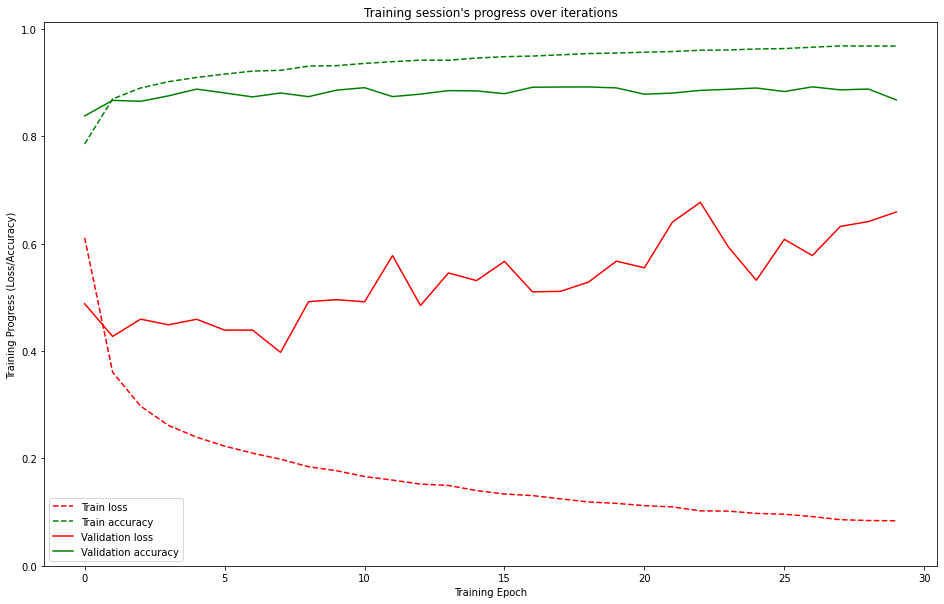

In [ ]:
# plot graph with batch_size = 64, n_epoch = 30
plt.figure(figsize=(16,10))
plt.plot(np.array(hist.history['loss']),"r--",label="Train loss")
plt.plot(np.array(hist.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(hist.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(hist.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
# Using batch_size = 64, n_epoch = 30
loss,accuracy = model.evaluate(x_test_segments,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Loss :",loss)

371/371 [==============================] - 17s 47ms/step - loss: 0.8167 - accuracy: 0.8392
Test Accuracy : 0.8391546607017517
Test Loss : 0.8166782855987549


In [ ]:
predictions = model.predict(x_test_segments)
class_labels = [1,2,3,4,5,6,7,8,9,10,11,12]
max_test = np.argmax(test_labels,axis=1)
max_predictions = np.argmax(predictions,axis=1)

149/149 [==============================] - 25s 163ms/step


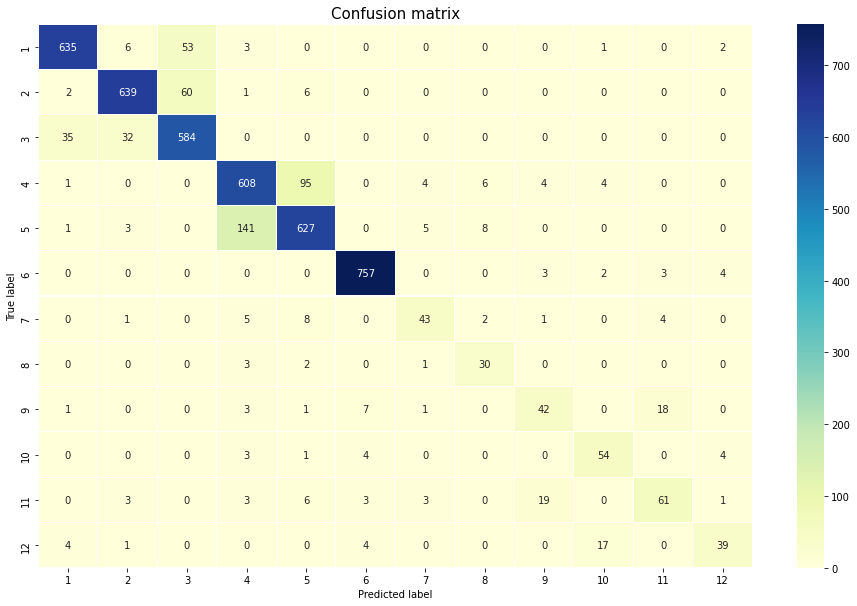

In [ ]:
conf_matrix = confusion_matrix(max_test,max_predictions)
plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix,
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot=True,
            linewidths=0.1,
            fmt='d',
            cmap='YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## CNN-LSTM Model:

*   Involves using CNN layers for feature extraction on input data
*   Combine with LSTMs to support sequence prediction


In [ ]:
# FINAL MODEL

#TODO: DONE

timesteps, features, outputs = x_train_segments.shape[1], x_train_segments.shape[2], labels.shape[1]
steps, length = 5, 50
newX = x_train_segments.reshape((x_train_segments.shape[0],steps,length,features))
newtestX = x_test_segments.reshape((x_test_segments.shape[0],steps,length,features))

callback = kr.callbacks.EarlyStopping(monitor='loss',patience=5)

CNNLSTM_final = Sequential()
CNNLSTM_final.add(TimeDistributed(Conv1D(filters=125,kernel_size=3,activation='relu'),
                            input_shape=(None,length,features)))
CNNLSTM_final.add(TimeDistributed(Conv1D(filters=125,kernel_size=3,activation='relu')))
CNNLSTM_final.add(TimeDistributed(Dropout(0.5)))
CNNLSTM_final.add(TimeDistributed(MaxPooling1D(pool_size=2)))
CNNLSTM_final.add(TimeDistributed(Flatten()))
CNNLSTM_final.add(LSTM(250))
CNNLSTM_final.add(Dense(labels.shape[1],activation='softmax'))

CNNLSTM_final.compile(loss='categorical_crossentropy',optimizer='adam',
                metrics=['accuracy',kr.metrics.Precision(),kr.metrics.Recall(),kr.metrics.AUC()])

CNNLSTM_final_results = CNNLSTM_final.fit(
    newX,labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[callback],
    verbose=1
)

Epoch 1/50
145/145 [==============================] - 59s 383ms/step - loss: 0.5756 - accuracy: 0.7839 - precision: 0.8652 - recall: 0.7148 - auc: 0.9852 - val_loss: 0.3780 - val_accuracy: 0.8878 - val_precision: 0.8993 - val_recall: 0.8783 - val_auc: 0.9828
Epoch 2/50
145/145 [==============================] - 51s 349ms/step - loss: 0.2315 - accuracy: 0.9140 - precision: 0.9278 - recall: 0.8984 - auc: 0.9972 - val_loss: 0.3489 - val_accuracy: 0.8891 - val_precision: 0.8942 - val_recall: 0.8818 - val_auc: 0.9898
Epoch 3/50
145/145 [==============================] - 51s 351ms/step - loss: 0.1680 - accuracy: 0.9346 - precision: 0.9434 - recall: 0.9241 - auc: 0.9985 - val_loss: 0.3169 - val_accuracy: 0.8965 - val_precision: 0.9020 - val_recall: 0.8891 - val_auc: 0.9880
Epoch 4/50
145/145 [==============================] - 52s 362ms/step - loss: 0.1258 - accuracy: 0.9534 - precision: 0.9586 - recall: 0.9480 - auc: 0.9992 - val_loss: 0.4114 - val_accuracy: 0.8809 - val_precision: 0.8887 - v

In [ ]:
# BASELINE MODEL

#TODO: DONE

timesteps, features, outputs = x_train_segments.shape[1], x_train_segments.shape[2], labels.shape[1]
steps, length = 5, 50
newX = x_train_segments.reshape((x_train_segments.shape[0],steps,length,features))
newtestX = x_test_segments.reshape((x_test_segments.shape[0],steps,length,features))

callback = kr.callbacks.EarlyStopping(monitor='loss',patience=5)

CNNLSTM_b = Sequential()
CNNLSTM_b.add(TimeDistributed(Conv1D(filters=250,kernel_size=3,activation='relu'),
                            input_shape=(None,length,features)))
CNNLSTM_b.add(TimeDistributed(Flatten()))
CNNLSTM_b.add(LSTM(250))
CNNLSTM_b.add(Dense(labels.shape[1],activation='softmax'))

CNNLSTM_b.compile(loss='categorical_crossentropy',optimizer='adam',
                metrics=['accuracy',kr.metrics.Precision(),kr.metrics.Recall(),kr.metrics.AUC()])

CNNLSTM_b_results = CNNLSTM_b.fit(
    newX,labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[callback],
    verbose=1
)

Epoch 1/50
145/145 [==============================] - 112s 753ms/step - loss: 0.6049 - accuracy: 0.7866 - precision_1: 0.8803 - recall_1: 0.6963 - auc_1: 0.9839 - val_loss: 0.4292 - val_accuracy: 0.8558 - val_precision_1: 0.8747 - val_recall_1: 0.8281 - val_auc_1: 0.9910
Epoch 2/50
145/145 [==============================] - 107s 737ms/step - loss: 0.2376 - accuracy: 0.9194 - precision_1: 0.9371 - recall_1: 0.8989 - auc_1: 0.9973 - val_loss: 0.3912 - val_accuracy: 0.8731 - val_precision_1: 0.8842 - val_recall_1: 0.8597 - val_auc_1: 0.9840
Epoch 3/50
145/145 [==============================] - 104s 715ms/step - loss: 0.1575 - accuracy: 0.9461 - precision_1: 0.9556 - recall_1: 0.9348 - auc_1: 0.9989 - val_loss: 0.4017 - val_accuracy: 0.8692 - val_precision_1: 0.8772 - val_recall_1: 0.8597 - val_auc_1: 0.9890
Epoch 4/50
145/145 [==============================] - 105s 727ms/step - loss: 0.1102 - accuracy: 0.9620 - precision_1: 0.9676 - recall_1: 0.9560 - auc_1: 0.9995 - val_loss: 0.3983 - va

KeyboardInterrupt: ignored

In [ ]:
# BASELINE + 1 FC LAYER 

# TODO: DONE

timesteps, features, outputs = x_train_segments.shape[1], x_train_segments.shape[2], labels.shape[1]
steps, length = 5, 50
newX = x_train_segments.reshape((x_train_segments.shape[0],steps,length,features))
newtestX = x_test_segments.reshape((x_test_segments.shape[0],steps,length,features))

callback = kr.callbacks.EarlyStopping(monitor='loss',patience=5)

CNNLSTM_dense = Sequential()
CNNLSTM_dense.add(TimeDistributed(Conv1D(filters=125,kernel_size=3,activation='relu'),
                            input_shape=(None,length,features)))
CNNLSTM_dense.add(TimeDistributed(Conv1D(filters=125,kernel_size=3,activation='relu')))
CNNLSTM_dense.add(TimeDistributed(MaxPooling1D(pool_size=2)))
CNNLSTM_dense.add(TimeDistributed(Flatten()))
CNNLSTM_dense.add(LSTM(250))
CNNLSTM_dense.add(Dense(250,activation='relu'))
CNNLSTM_dense.add(Dense(labels.shape[1],activation='softmax'))

CNNLSTM_dense.compile(loss='categorical_crossentropy',optimizer='adam',
                metrics=['accuracy',kr.metrics.Precision(),kr.metrics.Recall(),kr.metrics.AUC()])

CNNLSTM_dense_results = CNNLSTM_dense.fit(
    newX,labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[callback],
    verbose=1
)

Epoch 1/50
145/145 [==============================] - 32s 199ms/step - loss: 0.7013 - accuracy: 0.7325 - precision_3: 0.8396 - recall_3: 0.6456 - auc_3: 0.9772 - val_loss: 0.5526 - val_accuracy: 0.8164 - val_precision_3: 0.8289 - val_recall_3: 0.7908 - val_auc_3: 0.9832
Epoch 2/50
145/145 [==============================] - 27s 188ms/step - loss: 0.3191 - accuracy: 0.8812 - precision_3: 0.9017 - recall_3: 0.8616 - auc_3: 0.9942 - val_loss: 0.3402 - val_accuracy: 0.8757 - val_precision_3: 0.8849 - val_recall_3: 0.8657 - val_auc_3: 0.9935
Epoch 3/50
145/145 [==============================] - 28s 194ms/step - loss: 0.2421 - accuracy: 0.9091 - precision_3: 0.9212 - recall_3: 0.8980 - auc_3: 0.9966 - val_loss: 0.3704 - val_accuracy: 0.8701 - val_precision_3: 0.8758 - val_recall_3: 0.8644 - val_auc_3: 0.9846
Epoch 4/50
145/145 [==============================] - 29s 198ms/step - loss: 0.2104 - accuracy: 0.9153 - precision_3: 0.9246 - recall_3: 0.9050 - auc_3: 0.9973 - val_loss: 0.3569 - val_ac

In [ ]:
# BASELINE + 1FC WITH HEAVY REGULARIZATION

# TODO: DONE

timesteps, features, outputs = x_train_segments.shape[1], x_train_segments.shape[2], labels.shape[1]
steps, length = 5, 50
newX = x_train_segments.reshape((x_train_segments.shape[0],steps,length,features))
newtestX = x_test_segments.reshape((x_test_segments.shape[0],steps,length,features))

callback = kr.callbacks.EarlyStopping(monitor='loss',patience=5)

CNNLSTM_reg = Sequential()
CNNLSTM_reg.add(TimeDistributed(Conv1D(filters=125,kernel_size=3,activation='relu'),
                            input_shape=(None,length,features)))
CNNLSTM_reg.add(TimeDistributed(Dropout(0.5)))
CNNLSTM_reg.add(TimeDistributed(Conv1D(filters=125,kernel_size=3,activation='relu')))
CNNLSTM_reg.add(TimeDistributed(Dropout(0.5)))
CNNLSTM_reg.add(TimeDistributed(MaxPooling1D(pool_size=2)))
CNNLSTM_reg.add(TimeDistributed(Flatten()))
CNNLSTM_reg.add(LSTM(250))
CNNLSTM_reg.add(Dropout(0.5))
CNNLSTM_reg.add(Dense(250,activation='relu'))
CNNLSTM_reg.add(Dense(labels.shape[1],activation='softmax'))

CNNLSTM_reg.compile(loss='categorical_crossentropy',optimizer='adam',
                metrics=['accuracy',kr.metrics.Precision(),kr.metrics.Recall(),kr.metrics.AUC()])

CNNLSTM_reg_results = CNNLSTM_reg.fit(
    newX,labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[callback],
    verbose=1
)

Epoch 1/50
145/145 [==============================] - 33s 204ms/step - loss: 0.8633 - accuracy: 0.6552 - precision_1: 0.7952 - recall_1: 0.5326 - auc_1: 0.9659 - val_loss: 0.6062 - val_accuracy: 0.7445 - val_precision_1: 0.7636 - val_recall_1: 0.7246 - val_auc_1: 0.9828
Epoch 2/50
145/145 [==============================] - 29s 198ms/step - loss: 0.3879 - accuracy: 0.8539 - precision_1: 0.8765 - recall_1: 0.8270 - auc_1: 0.9919 - val_loss: 0.5363 - val_accuracy: 0.8190 - val_precision_1: 0.8331 - val_recall_1: 0.7977 - val_auc_1: 0.9836
Epoch 3/50
145/145 [==============================] - 29s 204ms/step - loss: 0.2950 - accuracy: 0.8880 - precision_1: 0.9023 - recall_1: 0.8731 - auc_1: 0.9949 - val_loss: 0.3867 - val_accuracy: 0.8601 - val_precision_1: 0.8684 - val_recall_1: 0.8545 - val_auc_1: 0.9888
Epoch 4/50
145/145 [==============================] - 31s 211ms/step - loss: 0.2472 - accuracy: 0.9025 - precision_1: 0.9156 - recall_1: 0.8919 - auc_1: 0.9962 - val_loss: 0.3365 - val_ac

In [ ]:
# BASELINE + NO POOLING

# TODO: DONE

timesteps, features, outputs = x_train_segments.shape[1], x_train_segments.shape[2], labels.shape[1]
steps, length = 5, 50
newX = x_train_segments.reshape((x_train_segments.shape[0],steps,length,features))
newtestX = x_test_segments.reshape((x_test_segments.shape[0],steps,length,features))

callback = kr.callbacks.EarlyStopping(monitor='loss',patience=5)

CNNLSTM_nopool = Sequential()
CNNLSTM_nopool.add(TimeDistributed(Conv1D(filters=125,kernel_size=3,activation='relu'),
                            input_shape=(None,length,features)))
CNNLSTM_nopool.add(TimeDistributed(Conv1D(filters=125,kernel_size=3,activation='relu')))
CNNLSTM_nopool.add(TimeDistributed(Flatten()))
CNNLSTM_nopool.add(LSTM(250))
CNNLSTM_nopool.add(Dense(labels.shape[1],activation='softmax'))

CNNLSTM_nopool.compile(loss='categorical_crossentropy',optimizer='adam',
                metrics=['accuracy',kr.metrics.Precision(),kr.metrics.Recall(),kr.metrics.AUC()])

CNNLSTM_nopool_results = CNNLSTM_nopool.fit(
    newX,labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[callback],
    verbose=1
)

Epoch 1/50
145/145 [==============================] - 39s 248ms/step - loss: 0.5719 - accuracy: 0.7896 - precision: 0.8606 - recall: 0.7295 - auc: 0.9851 - val_loss: 0.3890 - val_accuracy: 0.8696 - val_precision: 0.8861 - val_recall: 0.8558 - val_auc: 0.9866
Epoch 2/50
145/145 [==============================] - 37s 256ms/step - loss: 0.2336 - accuracy: 0.9099 - precision: 0.9254 - recall: 0.8948 - auc: 0.9972 - val_loss: 0.3460 - val_accuracy: 0.8922 - val_precision: 0.8993 - val_recall: 0.8857 - val_auc: 0.9844
Epoch 3/50
145/145 [==============================] - 42s 290ms/step - loss: 0.1675 - accuracy: 0.9359 - precision: 0.9420 - recall: 0.9270 - auc: 0.9985 - val_loss: 0.3527 - val_accuracy: 0.9082 - val_precision: 0.9150 - val_recall: 0.9047 - val_auc: 0.9847
Epoch 4/50
145/145 [==============================] - 35s 241ms/step - loss: 0.1330 - accuracy: 0.9472 - precision: 0.9512 - recall: 0.9398 - auc: 0.9990 - val_loss: 0.3652 - val_accuracy: 0.9000 - val_precision: 0.9058 - v

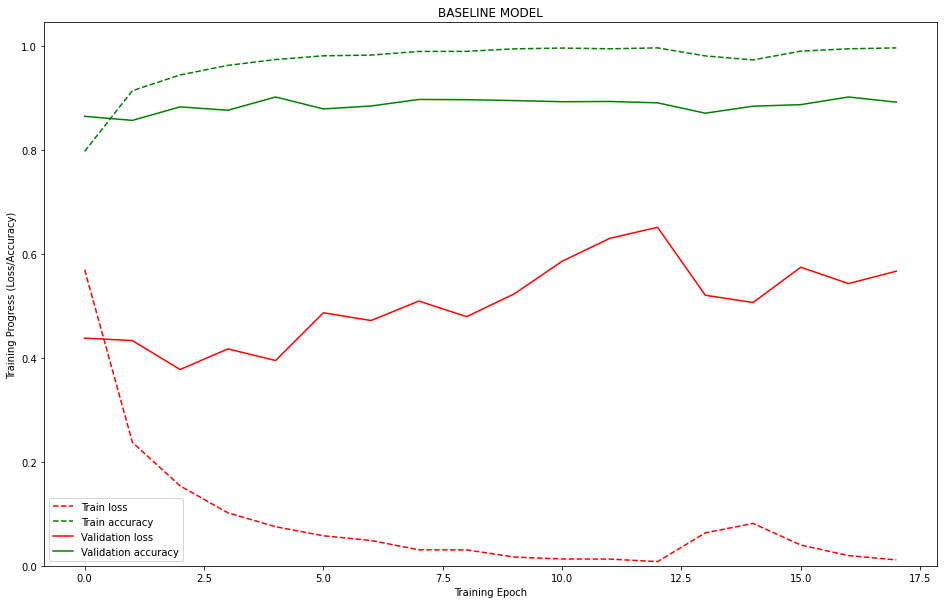

In [ ]:
## BASEBASEBASEBASELINE MODEL

plt.figure(figsize=(16,10))
plt.plot(np.array(CNNLSTM_b_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(CNNLSTM_b_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(CNNLSTM_b_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(CNNLSTM_b_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("BASELINE MODEL")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

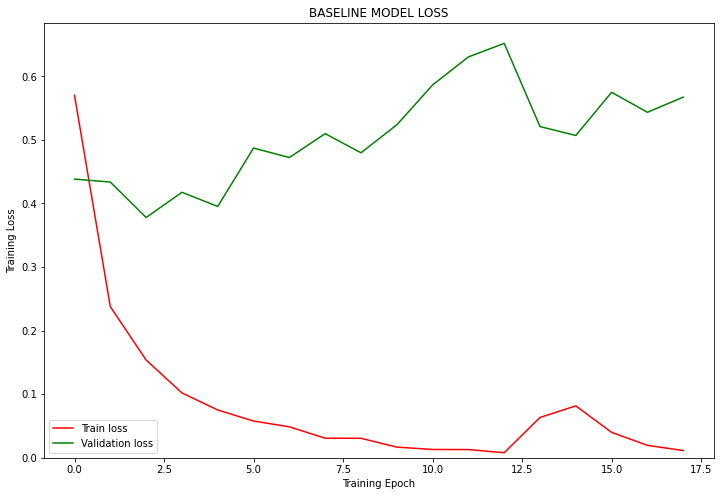

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.array(CNNLSTM_b_results.history['loss']),"r-",label="Train loss")
plt.plot(np.array(CNNLSTM_b_results.history['val_loss']),"g-",label="Validation loss")
plt.title("BASELINE MODEL LOSS")
plt.legend(loc='lower left')
plt.ylabel('Training Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

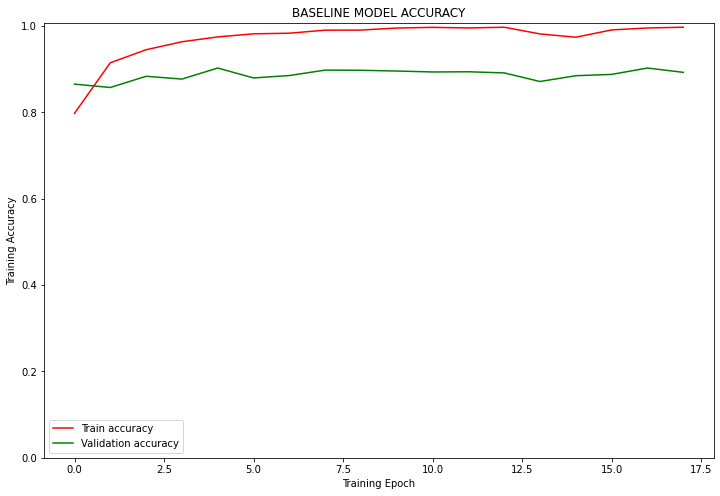

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.array(CNNLSTM_b_results.history['accuracy']),"r-",label="Train accuracy")
plt.plot(np.array(CNNLSTM_b_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("BASELINE MODEL ACCURACY")
plt.legend(loc='lower left')
plt.ylabel('Training Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

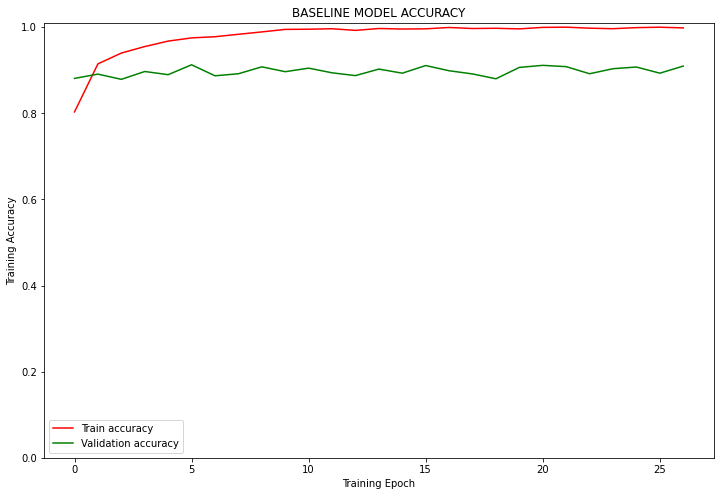

In [ ]:
# FINAL MODEL

plt.figure(figsize=(12,8))
plt.plot(np.array(CNNLSTM_final_results.history['accuracy']),"r-",label="Train accuracy")
plt.plot(np.array(CNNLSTM_final_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("BASELINE MODEL ACCURACY")
plt.legend(loc='lower left')
plt.ylabel('Training Accuracy')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

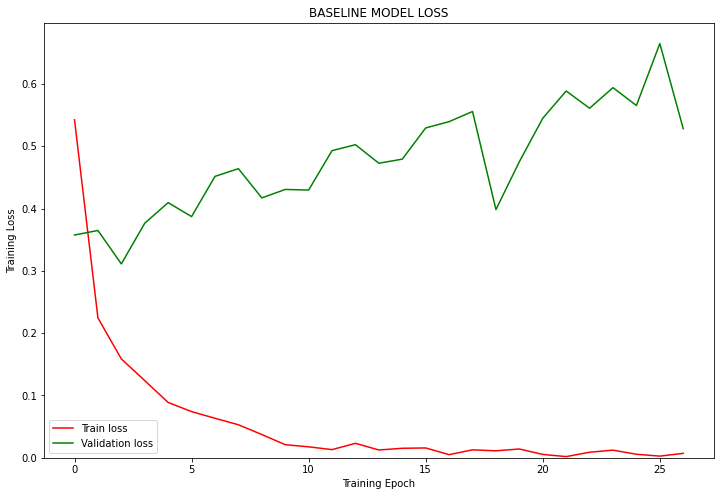

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(np.array(CNNLSTM_final_results.history['loss']),"r-",label="Train loss")
plt.plot(np.array(CNNLSTM_final_results.history['val_loss']),"g-",label="Validation loss")
plt.title("BASELINE MODEL LOSS")
plt.legend(loc='lower left')
plt.ylabel('Training Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

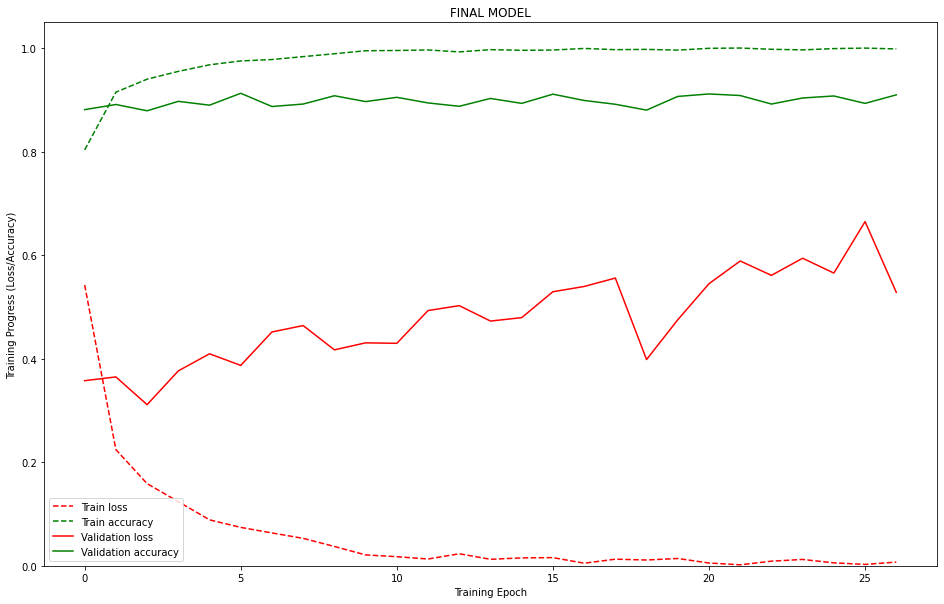

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(np.array(CNNLSTM_final_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(CNNLSTM_final_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(CNNLSTM_final_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(CNNLSTM_final_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("FINAL MODEL")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

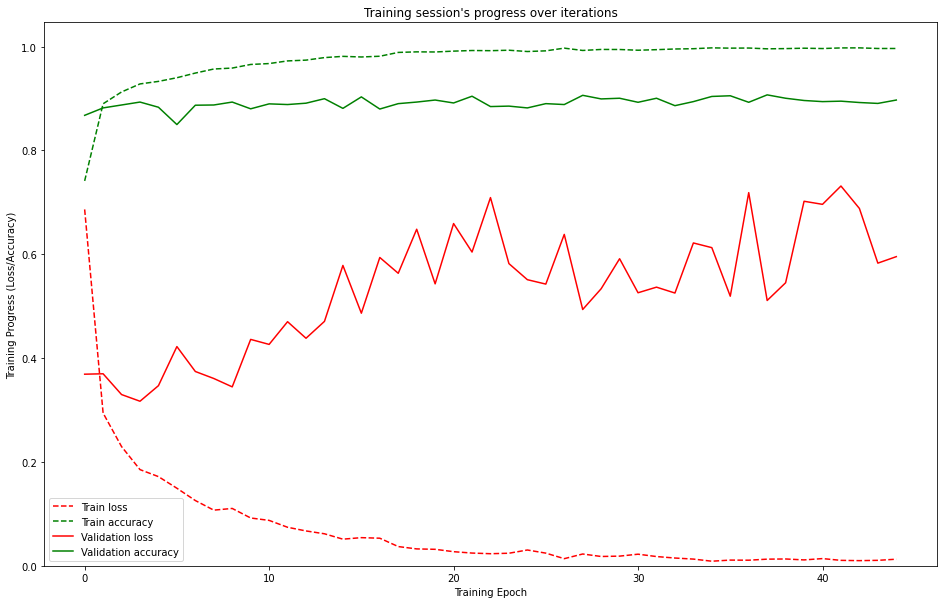

In [ ]:
# BASELINE PLOT patience=10

plt.figure(figsize=(16,10))
plt.plot(np.array(CNNLSTM_base_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(CNNLSTM_base_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(CNNLSTM_base_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(CNNLSTM_base_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

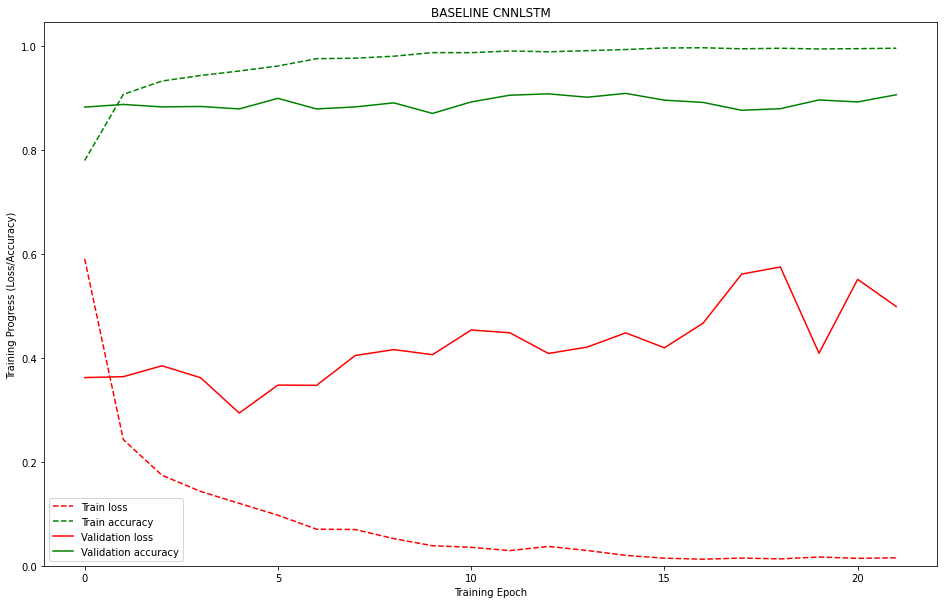

In [ ]:
# BASELINE PLOT patience=5

plt.figure(figsize=(16,10))
plt.plot(np.array(CNNLSTM_base_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(CNNLSTM_base_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(CNNLSTM_base_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(CNNLSTM_base_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("BASELINE CNNLSTM")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

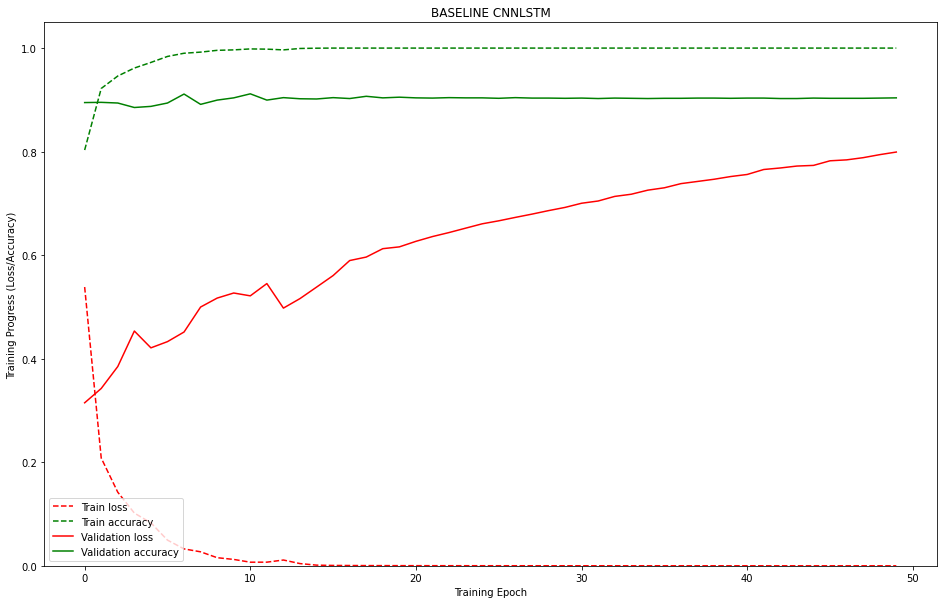

In [ ]:
# BASELINE + CONV + POOLING

plt.figure(figsize=(16,10))
plt.plot(np.array(CNNLSTM_base_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(CNNLSTM_base_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(CNNLSTM_base_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(CNNLSTM_base_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("BASELINE CNNLSTM")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

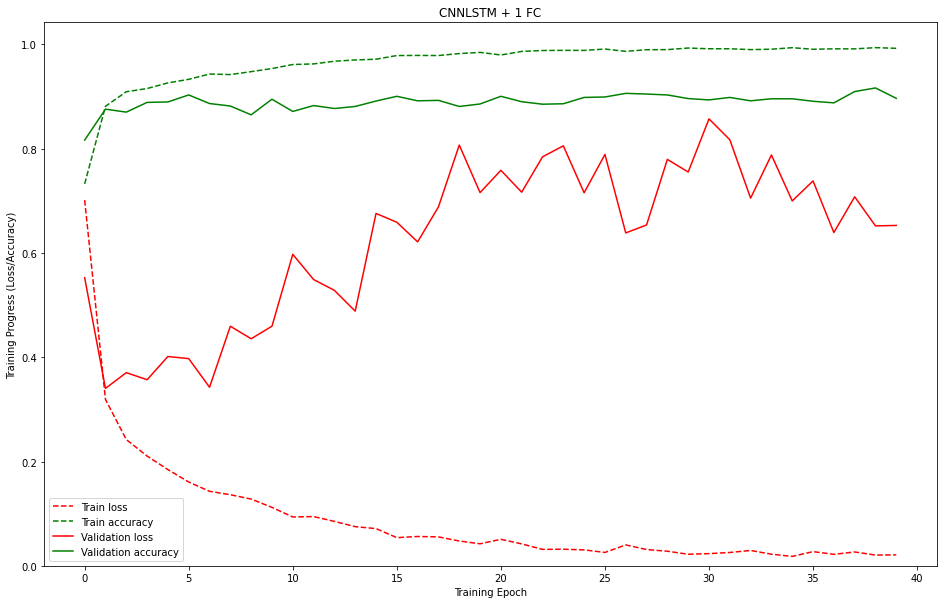

In [ ]:
# BASELINE + 1FC PLOT 

plt.figure(figsize=(16,10))
plt.plot(np.array(CNNLSTM_dense_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(CNNLSTM_dense_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(CNNLSTM_dense_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(CNNLSTM_dense_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("CNNLSTM + 1 FC")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

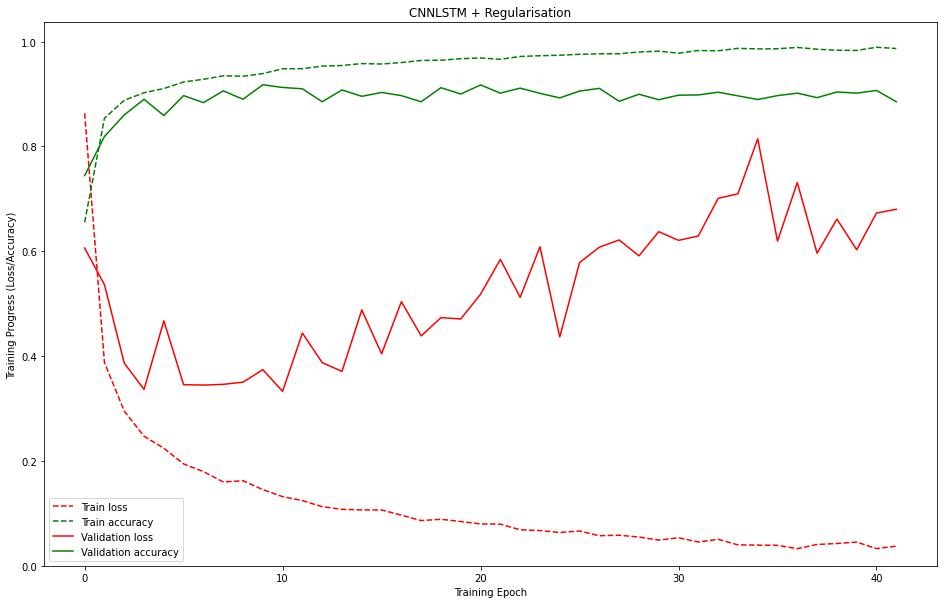

In [ ]:
# BASELINE + REG PLOT 

plt.figure(figsize=(16,10))
plt.plot(np.array(CNNLSTM_reg_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(CNNLSTM_reg_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(CNNLSTM_reg_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(CNNLSTM_reg_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("CNNLSTM + Regularisation")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

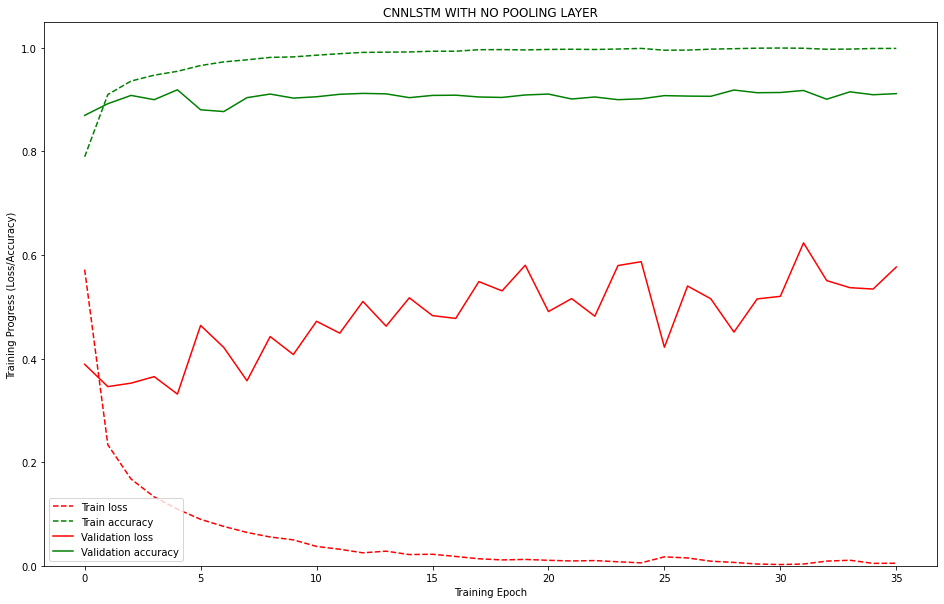

In [ ]:
# CNNLSTM W NO POOLING

plt.figure(figsize=(16,10))
plt.plot(np.array(CNNLSTM_nopool_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(CNNLSTM_nopool_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(CNNLSTM_nopool_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(CNNLSTM_nopool_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("CNNLSTM WITH NO POOLING LAYER")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()


In [ ]:
# BASELINE MODEL WITH PATIENCE=10
loss,accuracy,precision,recall = CNNLSTM_base.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Precision :",precision)
print("Test Recall :",recall)
print("Test Loss :",loss)

75/75 [==============================] - 3s 46ms/step - loss: 0.4207 - accuracy: 0.8577 - precision_6: 0.8786 - recall_6: 0.8352
Test Accuracy : 0.857745885848999
Test Precision : 0.8785523772239685
Test Recall : 0.8351625204086304
Test Loss : 0.4207233190536499


In [ ]:
# BASELINE MODEL WITH PATIENCE=5
loss,accuracy,precision,recall,AUC = CNNLSTM_base.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Precision :",precision)
print("Test Recall :",recall)
print("Test Loss :",loss)
print("Test AUC-ROC :",AUC)

75/75 [==============================] - 3s 45ms/step - loss: 0.3841 - accuracy: 0.9097 - precision_2: 0.9126 - recall_2: 0.9076 - auc_2: 0.9864
Test Accuracy : 0.9096665382385254
Test Precision : 0.912563681602478
Test Recall : 0.9075559377670288
Test Loss : 0.3840733468532562
Test AUC-ROC : 0.9864065051078796


In [ ]:
# BASELINE MODEL + 1 FC 
loss,accuracy,precision,recall,AUC = CNNLSTM_dense.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Precision :",precision)
print("Test Recall :",recall)
print("Test Loss :",loss)
print("Test AUC-ROC :",AUC)

75/75 [==============================] - 4s 46ms/step - loss: 0.5412 - accuracy: 0.9160 - precision_3: 0.9187 - recall_3: 0.9139 - auc_3: 0.9764
Test Accuracy : 0.9159983396530151
Test Precision : 0.9187353849411011
Test Recall : 0.9138877391815186
Test Loss : 0.5412181615829468
Test AUC-ROC : 0.9763970971107483


In [ ]:
# BASELINE MODEL WITH HEAVY REGULARIZATION
loss,accuracy,precision,recall,AUC = CNNLSTM_reg.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Precision :",precision)
print("Test Recall :",recall)
print("Test Loss :",loss)
print("Test AUC-ROC: ",AUC)

75/75 [==============================] - 6s 74ms/step - loss: 0.5782 - accuracy: 0.8858 - precision_1: 0.8875 - recall_1: 0.8854 - auc_1: 0.9787
Test Accuracy : 0.8858168125152588
Test Precision : 0.8874550461769104
Test Recall : 0.8853946924209595
Test Loss : 0.578240156173706
Test AUC-ROC:  0.9786686897277832


In [ ]:
# BASELINE MODEL WITH NO POOLING
loss,accuracy,precision,recall,AUC = CNNLSTM_nopool.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Precision :",precision)
print("Test Recall :",recall)
print("Test Loss :",loss)
print("Test AUC-ROC :",AUC)

75/75 [==============================] - 5s 69ms/step - loss: 0.5413 - accuracy: 0.9067 - precision: 0.9107 - recall: 0.9042 - auc: 0.9796
Test Accuracy : 0.9067116975784302
Test Precision : 0.9107142686843872
Test Recall : 0.9041789770126343
Test Loss : 0.541313886642456
Test AUC-ROC : 0.9795657396316528


In [ ]:
# BASEBASEBASEBASE MODEL

loss,accuracy,precision,recall,AUC = CNNLSTM_b.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Precision :",precision)
print("Test Recall :",recall)
print("Test Loss :",loss)
print("Test AUC-ROC :",AUC)

75/75 [==============================] - 15s 196ms/step - loss: 0.5003 - accuracy: 0.8892 - precision_2: 0.8981 - recall_2: 0.8871 - auc_2: 0.9804
Test Accuracy : 0.8891937732696533
Test Precision : 0.8980769515037537
Test Recall : 0.8870831727981567
Test Loss : 0.5003268718719482
Test AUC-ROC : 0.9803617000579834


In [ ]:
CNNLSTM_b.save('baseline_model.tf')

In [ ]:
# BASELINE + CONV + POOLING
loss,accuracy,precision,recall,AUC = CNNLSTM_base.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Precision :",precision)
print("Test Recall :",recall)
print("Test Loss :",loss)
print("Test AUC-ROC :",AUC)

75/75 [==============================] - 8s 99ms/step - loss: 0.5232 - accuracy: 0.9187 - precision_3: 0.9223 - recall_3: 0.9168 - auc_3: 0.9800
Test Accuracy : 0.9187420606613159
Test Precision : 0.9222930073738098
Test Recall : 0.916842520236969
Test Loss : 0.5231803059577942
Test AUC-ROC : 0.9799941182136536


In [ ]:
# FINAL

loss,accuracy,precision,recall,AUC = CNNLSTM_final.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Precision :",precision)
print("Test Recall :",recall)
print("Test Loss :",loss)
print("Test AUC-ROC :",AUC)

75/75 [==============================] - 7s 96ms/step - loss: 0.4292 - accuracy: 0.9114 - precision_5: 0.9172 - recall_5: 0.9099 - auc_5: 0.9826
Test Accuracy : 0.9113550186157227
Test Precision : 0.9172340631484985
Test Recall : 0.909877598285675
Test Loss : 0.4292352497577667
Test AUC-ROC : 0.9825899600982666


149/149 [==============================] - 4s 21ms/step


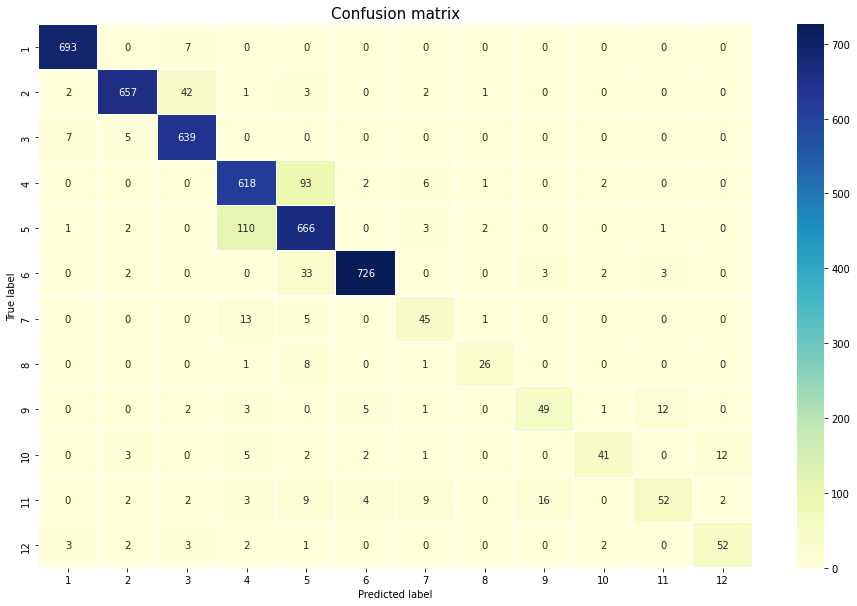

In [ ]:
## NEW

predictions = CNNLSTM.predict(newtestX)
class_labels = [1,2,3,4,5,6,7,8,9,10,11,12]
max_test = np.argmax(test_labels,axis=1)
max_predictions = np.argmax(predictions,axis=1)
conf_matrix = confusion_matrix(max_test,max_predictions)
plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix,
            xticklabels=label_list,
            yticklabels=label_list,
            annot=True,
            linewidths=0.1,
            fmt='d',
            cmap='YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

149/149 [==============================] - 20s 135ms/step


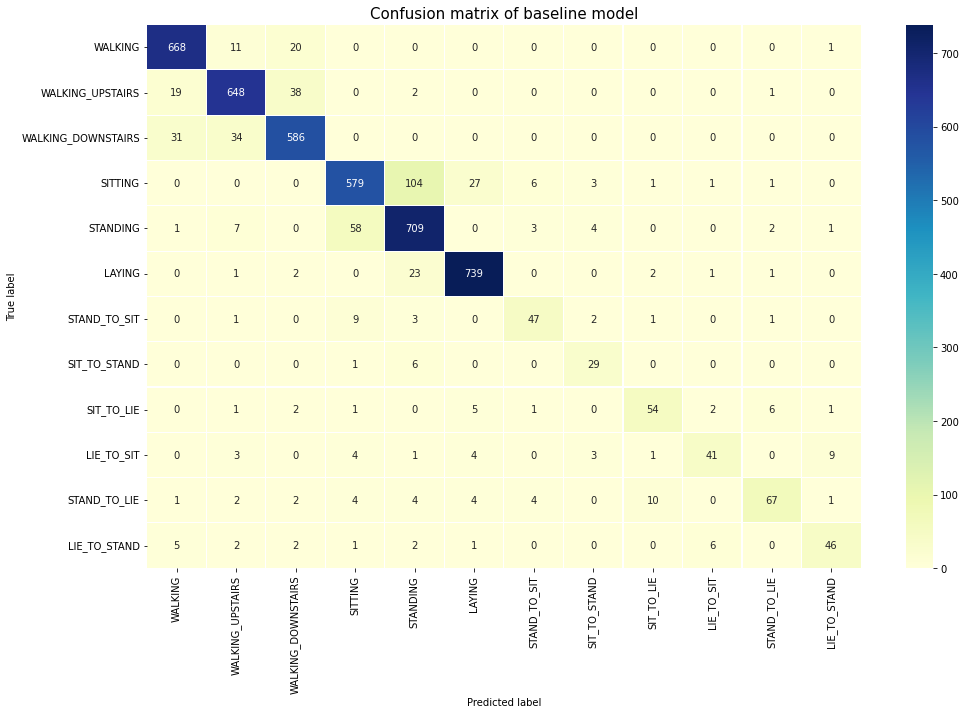

In [ ]:
predictions = CNNLSTM_b.predict(newtestX)
class_labels = [1,2,3,4,5,6,7,8,9,10,11,12]
max_test = np.argmax(test_labels,axis=1)
max_predictions = np.argmax(predictions,axis=1)
conf_matrix = confusion_matrix(max_test,max_predictions)
plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix,
            xticklabels=label_list,
            yticklabels=label_list,
            annot=True,
            linewidths=0.1,
            fmt='d',
            cmap='YlGnBu')
plt.title("Confusion matrix of baseline model", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
conf_matrix
grp_names = ["True Neg","False Pos","False Neg","True Pos"]
grp_counts = ["{0}".format(v) for v in conf_matrix.flatten()]
grp_percent = ["{0:.2%}".format(v) for v in conf_matrix.flatten()/np.sum(conf_matrix)]
lab = [f"{n}\n{c}\n{p}" for n,c,p in zip(grp_names,grp_counts,grp_percent)]
lab = np.asarray(lab).reshape(2,2)

sns.heatmap(conf_matrix,annot=lab,fmt="",cmap='Blues')

In [ ]:
final = load_model("CNNLSTM_final.tf")
base = load_model("baseline_model.tf")

149/149 [==============================] - 11s 71ms/step


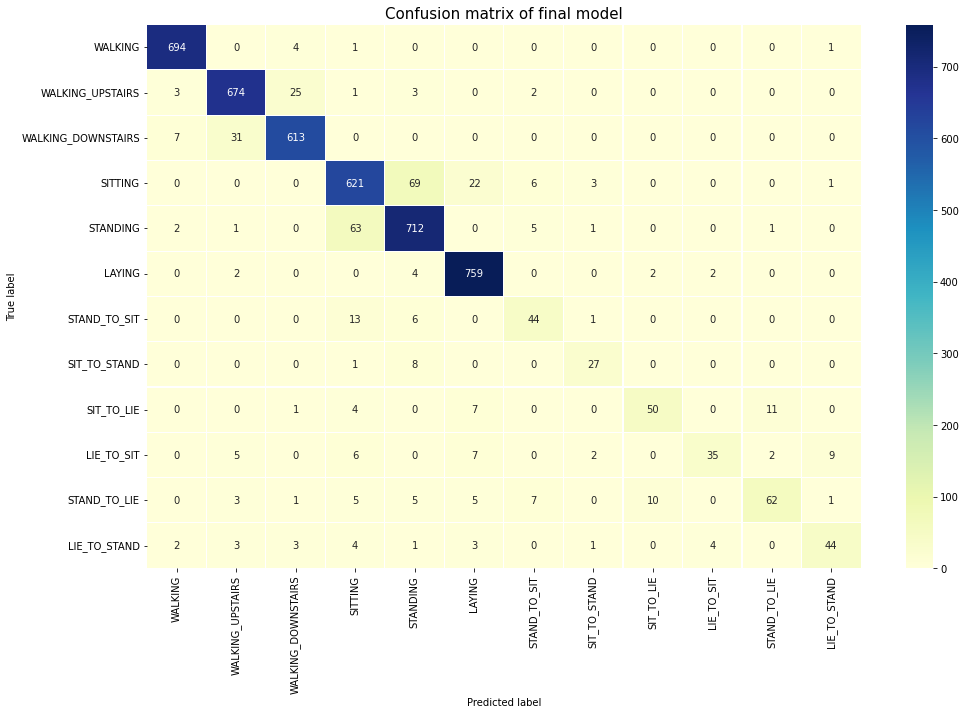

In [ ]:
predictions = final.predict(newtestX)
max_test = np.argmax(test_labels,axis=1)
max_predictions = np.argmax(predictions,axis=1)
conf_matrix = confusion_matrix(max_test,max_predictions)
plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix,
            xticklabels=label_list,
            yticklabels=label_list,
            annot=True,
            linewidths=0.1,
            fmt='d',
            cmap='YlGnBu')
plt.title("Confusion matrix of final model", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(conf_matrix.sum(axis=0))
print(np.diag(conf_matrix))
print(conf_matrix)

[708 719 647 719 808 803  64  35  62  41  76  56]
[694 674 613 621 712 759  44  27  50  35  62  44]
[[694   0   4   1   0   0   0   0   0   0   0   1]
 [  3 674  25   1   3   0   2   0   0   0   0   0]
 [  7  31 613   0   0   0   0   0   0   0   0   0]
 [  0   0   0 621  69  22   6   3   0   0   0   1]
 [  2   1   0  63 712   0   5   1   0   0   1   0]
 [  0   2   0   0   4 759   0   0   2   2   0   0]
 [  0   0   0  13   6   0  44   1   0   0   0   0]
 [  0   0   0   1   8   0   0  27   0   0   0   0]
 [  0   0   1   4   0   7   0   0  50   0  11   0]
 [  0   5   0   6   0   7   0   2   0  35   2   9]
 [  0   3   1   5   5   5   7   0  10   0  62   1]
 [  2   3   3   4   1   3   0   1   0   4   0  44]]


0.6262626262626263 0.8157894736842105 0.9892359645420008


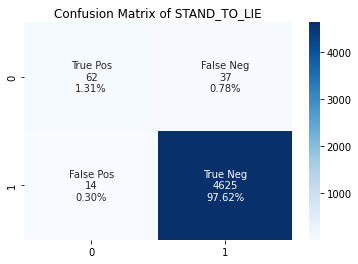

In [ ]:
# STAND_TO_LIE, index= 10
predictions = final.predict(newtestX)
max_test = np.argmax(test_labels,axis=1)
max_predictions = np.argmax(predictions,axis=1)
conf_matrix = confusion_matrix(max_test,max_predictions)
FP = (conf_matrix.sum(axis=0)[10] - np.diag(conf_matrix)[10]).astype(float)
FN = (conf_matrix.sum(axis=1)[10] - np.diag(conf_matrix)[10]).astype(float)
TP = (np.diag(conf_matrix)[10]).astype(float)
TN = (conf_matrix.sum() - (FP+FN+TP)).astype(float)
stand_to_lie_matrix = np.asarray([[TP,FN],[FP,TN]])
grp_name = ['True Pos','False Neg','False Pos','True Neg']
grp_count = ["{0:0.0f}".format(v) for v in stand_to_lie_matrix.flatten()]
grp_percent = ["{0:.2%}".format(v) for v in stand_to_lie_matrix.flatten()/np.sum(stand_to_lie_matrix)]
lab = [f"{i}\n{j}\n{k}" for i,j,k in zip(grp_name,grp_count,grp_percent)]
lab = np.asarray(lab).reshape(2,2)
sns.heatmap(stand_to_lie_matrix,annot=lab,fmt='',cmap='Blues')
plt.title("Confusion Matrix of STAND_TO_LIE")
recall = TP/(TP+FN)
precision = TP/(TP+FP)
acc = (TP+TN)/(TP+FP+TN+FN)

print(recall,precision,acc)

0.684931506849315 0.8064516129032258 0.9926129168425496


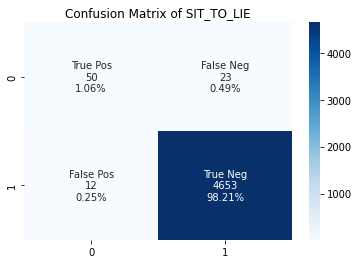

In [ ]:
# SIT_TO_LIE, index = 8
FP = (conf_matrix.sum(axis=0)[8] - np.diag(conf_matrix)[8]).astype(float)
FN = (conf_matrix.sum(axis=1)[8] - np.diag(conf_matrix)[8]).astype(float)
TP = (np.diag(conf_matrix)[8]).astype(float)
TN = (conf_matrix.sum() - (FP+FN+TP)).astype(float)
sit_to_lie_matrix = np.asarray([[TP,FN],[FP,TN]])
grp_name = ['True Pos','False Neg','False Pos','True Neg']
grp_count = ["{0:0.0f}".format(v) for v in sit_to_lie_matrix.flatten()]
grp_percent = ["{0:.2%}".format(v) for v in sit_to_lie_matrix.flatten()/np.sum(sit_to_lie_matrix)]
lab = [f"{i}\n{j}\n{k}" for i,j,k in zip(grp_name,grp_count,grp_percent)]
lab = np.asarray(lab).reshape(2,2)
sns.heatmap(sit_to_lie_matrix,annot=lab,fmt='',cmap='Blues')
plt.title("Confusion Matrix of SIT_TO_LIE")
recall = TP/(TP+FN)
precision = TP/(TP+FP)
acc = (TP+TN)/(TP+FP+TN+FN)

print(recall,precision,acc)

In [ ]:
# FINAL MODEL
print(classification_report(max_test,max_predictions,target_names=label_list))

                    precision    recall  f1-score   support

           WALKING       0.98      0.99      0.99       700
  WALKING_UPSTAIRS       0.94      0.95      0.94       708
WALKING_DOWNSTAIRS       0.95      0.94      0.94       651
           SITTING       0.86      0.86      0.86       722
          STANDING       0.88      0.91      0.89       785
            LAYING       0.95      0.99      0.97       769
      STAND_TO_SIT       0.69      0.69      0.69        64
      SIT_TO_STAND       0.77      0.75      0.76        36
        SIT_TO_LIE       0.81      0.68      0.74        73
        LIE_TO_SIT       0.85      0.53      0.65        66
      STAND_TO_LIE       0.82      0.63      0.71        99
      LIE_TO_STAND       0.79      0.68      0.73        65

          accuracy                           0.91      4738
         macro avg       0.86      0.80      0.82      4738
      weighted avg       0.91      0.91      0.91      4738



In [ ]:
mappings = {"WALKING":1,
              "WALKING_UPSTAIRS":2,
              "WALKING_DOWNSTAIRS":3,
              "SITTING":4,
              "STANDING":5,
              "LAYING":6,
              "STAND_TO_SIT":7,
              "SIT_TO_STAND":8, 
              "SIT_TO_LIE":9, 
              "LIE_TO_SIT":10,
              "STAND_TO_LIE":11,
              "LIE_TO_STAND":12}

In [ ]:
#SIT_TO_LIE, CLASS=9
# STAND_TO_LIE, CLASS=11


id = np.asarray(range(newtestX.shape[0]))
f = pd.DataFrame(data=id,columns=['id'])
f['Actual']=max_test
f['Pred']=max_predictions
sit_to_lie = f[f['Actual']==8]
sit_to_lie_wrong = sit_to_lie[sit_to_lie['Actual']!= sit_to_lie['Pred']]
si2l_dist = pd.crosstab(index=sit_to_lie_wrong['Pred'],columns="count")
si2l_dist

col_0,count
Pred,
2,1
3,4
5,7
10,11


In [ ]:
a = sit_to_lie_wrong
a = a['Pred'].replace(label_dict)
a

117               STANDING
355             LIE_TO_SIT
604     WALKING_DOWNSTAIRS
608               STANDING
861     WALKING_DOWNSTAIRS
865               STANDING
1101            LIE_TO_SIT
1102            LIE_TO_SIT
1103            LIE_TO_SIT
1339            LIE_TO_SIT
1340            LIE_TO_SIT
1341            LIE_TO_SIT
1807      WALKING_UPSTAIRS
1808            LIE_TO_SIT
1809              STANDING
2844              STANDING
3126    WALKING_DOWNSTAIRS
3130              STANDING
3720            LIE_TO_SIT
3997    WALKING_DOWNSTAIRS
3999            LIE_TO_SIT
4002            LIE_TO_SIT
4283              STANDING
Name: Pred, dtype: object

In [ ]:
stand_to_lie = f[f['Actual']==10]
stand_to_lie_wrong = stand_to_lie[stand_to_lie['Actual']!= stand_to_lie['Pred']]
stand_to_lie_wrong['Pred'].value_counts().idxmax()
#stand_to_lie_wrong
s2l_dist = pd.crosstab(index=stand_to_lie_wrong['Pred'],columns="count")
s2l_dist

col_0,count
Pred,
1,3
2,1
3,5
4,5
5,5
6,7
8,10
11,1


In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
# consider frame 1101, 1102, 1103
frame = newtestX[1101].reshape(250,6)
vis_1101 = pd.DataFrame(data=frame,columns=['ax','ay','az','gx','gy','gz'])
iter=np.arange(vis_1101.shape[0])

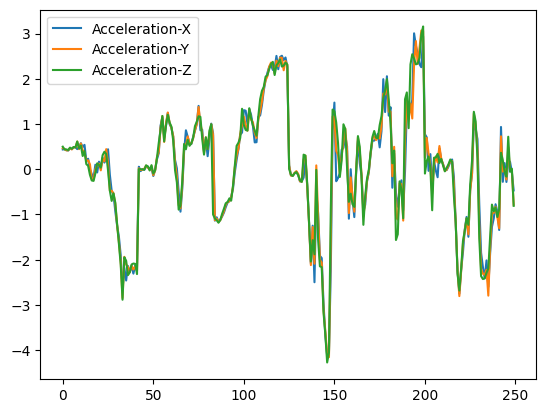

In [ ]:
# ACTUALLY SIT_TO_LIE, PREDICTED AS STAND_TO_LIE
a = plt.figure()
plt.plot(iter,vis_1101['ax'],iter,vis_1101['ay'],iter,vis_1101['az'])
plt.legend(['Acceleration-X','Acceleration-Y','Acceleration-Z'])

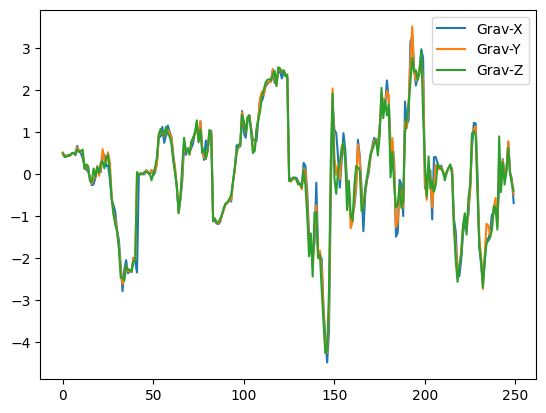

In [ ]:
# ACTUALLY SIT_TO_LIE, PREDICTED AS STAND_TO_LIE
g = plt.figure()
plt.plot(iter,vis_1101['gx'],iter,vis_1101['gy'],iter,vis_1101['gz'])
plt.legend(['Grav-X','Grav-Y','Grav-Z'])

In [ ]:
frame = newtestX[1101]
vis_1101 = pd.DataFrame(data=frame[0],columns=['ax','ay','az','gx','gy','gz'])
iter=np.arange(vis_1101.shape[0])

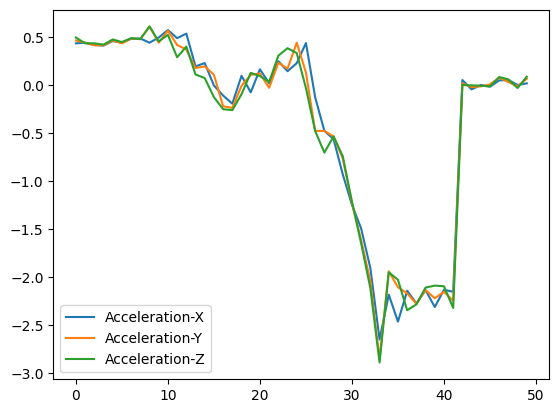

In [ ]:
a = plt.figure()
plt.plot(iter,vis_1101['ax'],iter,vis_1101['ay'],iter,vis_1101['az'])
plt.legend(['Acceleration-X','Acceleration-Y','Acceleration-Z'])

In [ ]:
fr = newtestX[1533]
vis_1533 = pd.DataFrame(data=fr[0],columns=['ax','ay','az','gx','gy','gz'])
i = np.arange(vis_1533.shape[0])

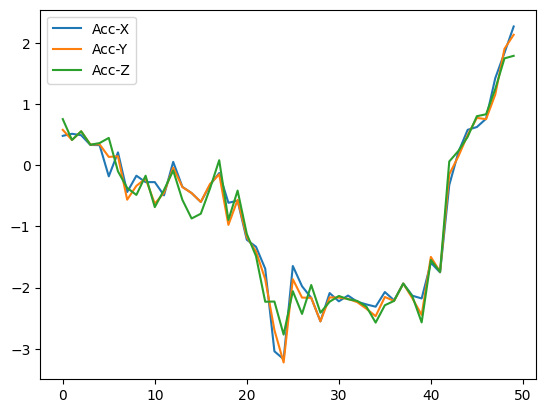

In [ ]:
as2l = plt.figure()
plt.clf()
plt.plot(i,vis_1533['ax'],i,vis_1533['ay'],i,vis_1533['az'])
plt.legend(['Acc-X','Acc-Y','Acc-Z'])

In [ ]:
# consider frame 1533, ACTUAL STAND_TO_LIE

fr = newtestX[1533].reshape(250,6)
vis_1533 = pd.DataFrame(data=fr,columns=['ax','ay','az','gx','gy','gz'])
i = np.arange(vis_1533.shape[0])

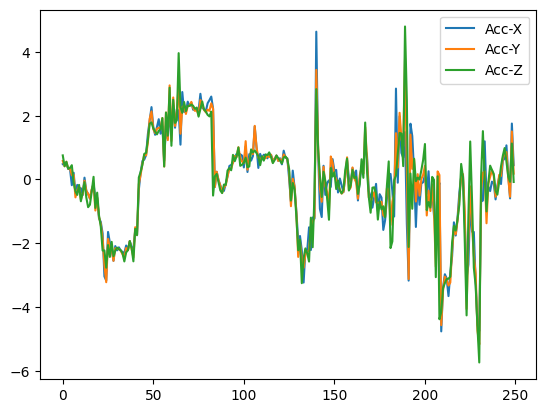

In [ ]:
as2l = plt.figure()
plt.clf()
plt.plot(i,vis_1533['ax'],i,vis_1533['ay'],i,vis_1533['az'])
plt.legend(['Acc-X','Acc-Y','Acc-Z'])

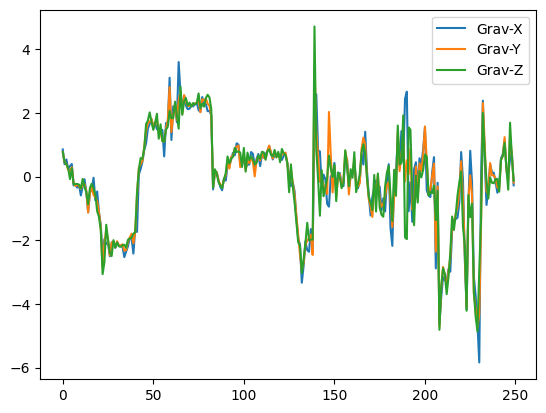

In [ ]:
gs2l = plt.figure()
plt.plot(i,vis_1533['gx'],i,vis_1533['gy'],i,vis_1533['gz'])
plt.legend(['Grav-X','Grav-Y','Grav-Z'])

In [ ]:
base_predictions = base.predict(newtestX)
max_test = np.argmax(test_labels,axis=1)
base_max_predictions = np.argmax(base_predictions,axis=1)
print(classification_report(max_test,base_max_predictions,target_names=label_list))

 11/149 [=>............................] - ETA: 28s

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Confusion Matrix of STAND_TO_LIE')

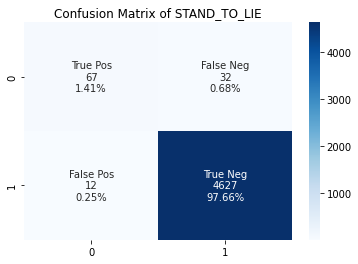

In [ ]:
# BASE MODEL, STAND_TO_LIE

base_conf_matrix = confusion_matrix(max_test,base_max_predictions)
FP = (base_conf_matrix.sum(axis=0)[10] - np.diag(base_conf_matrix)[10]).astype(float)
FN = (base_conf_matrix.sum(axis=1)[10] - np.diag(base_conf_matrix)[10]).astype(float)
TP = (np.diag(base_conf_matrix)[10]).astype(float)
TN = (base_conf_matrix.sum() - (FP+FN+TP)).astype(float)
base_stand_to_lie_matrix = np.asarray([[TP,FN],[FP,TN]])
grp_name = ['True Pos','False Neg','False Pos','True Neg']
grp_count = ["{0:0.0f}".format(v) for v in base_stand_to_lie_matrix.flatten()]
grp_percent = ["{0:.2%}".format(v) for v in base_stand_to_lie_matrix.flatten()/np.sum(base_stand_to_lie_matrix)]
lab = [f"{i}\n{j}\n{k}" for i,j,k in zip(grp_name,grp_count,grp_percent)]
lab = np.asarray(lab).reshape(2,2)
sns.heatmap(base_stand_to_lie_matrix,annot=lab,fmt='',cmap='Blues')
plt.title("Confusion Matrix of STAND_TO_LIE")

Text(0.5, 1.0, 'Confusion Matrix of SIT_TO_LIE')

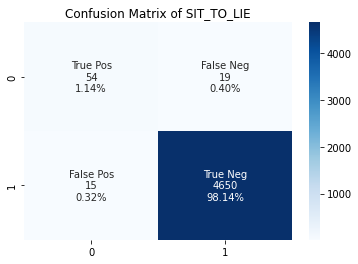

In [ ]:
# BASE MODEL, SIT_TO_LIE
FP = (base_conf_matrix.sum(axis=0)[8] - np.diag(base_conf_matrix)[8]).astype(float)
FN = (base_conf_matrix.sum(axis=1)[8] - np.diag(base_conf_matrix)[8]).astype(float)
TP = (np.diag(base_conf_matrix)[8]).astype(float)
TN = (base_conf_matrix.sum() - (FP+FN+TP)).astype(float)
base_sit_to_lie_matrix = np.asarray([[TP,FN],[FP,TN]])
grp_name = ['True Pos','False Neg','False Pos','True Neg']
grp_count = ["{0:0.0f}".format(v) for v in base_sit_to_lie_matrix.flatten()]
grp_percent = ["{0:.2%}".format(v) for v in base_sit_to_lie_matrix.flatten()/np.sum(base_sit_to_lie_matrix)]
lab = [f"{i}\n{j}\n{k}" for i,j,k in zip(grp_name,grp_count,grp_percent)]
lab = np.asarray(lab).reshape(2,2)
sns.heatmap(base_sit_to_lie_matrix,annot=lab,fmt='',cmap='Blues')
plt.title("Confusion Matrix of SIT_TO_LIE")

## ConvLSTM Network Model


*   An extension of CNN-LSTM idea
*   Perform the convolutions of CNN as part of the LSTM

*   Used for spatio-temporal data

### Difference from LSTM and CNN-LSTM

*   LSTM reads data in directly in order to calculate internal state and state transitions
*   CNN-LSTM inteprets output from CNN models
*   ConvLSTM uses convolutions directly as part of reading inputs into the LSTM units themselves


Ref: https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/






In [ ]:
# Need to reshape to include one more dimension for row, which we put as 1

timesteps, features, outputs = x_train_segments.shape[1], x_train_segments.shape[2], labels.shape[1]
steps, length = 2, 25
newX = x_train_segments.reshape((x_train_segments.shape[0],steps,1,length,features))
newtestX = x_test_segments.reshape((x_test_segments.shape[0],steps,1,length,features))

convLSTM = Sequential()
convLSTM.add(ConvLSTM2D(filters=250,kernel_size=(1,3),activation='relu',
                        input_shape=(steps,1,length,features)))
convLSTM.add(Dropout(0.5))
convLSTM.add(Flatten())
convLSTM.add(Dense(250,activation='relu'))
convLSTM.add(Dense(outputs,activation='softmax'))

convLSTM.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])

In [ ]:
## NEW

timesteps, features, outputs = x_train_segments.shape[1], x_train_segments.shape[2], labels.shape[1]
steps, length = 5, 50
newX = x_train_segments.reshape((x_train_segments.shape[0],steps,1,length,features))
newtestX = x_test_segments.reshape((x_test_segments.shape[0],steps,1,length,features))

callback = kr.callbacks.EarlyStopping(monitor='loss',patience=5)

convLSTM = Sequential()
convLSTM.add(ConvLSTM2D(filters=250,kernel_size=(1,3),activation='relu',
                        input_shape=(steps,1,length,features)))
convLSTM.add(Dropout(0.5))
convLSTM.add(Flatten())
convLSTM.add(Dense(250,activation='relu'))
convLSTM.add(Dense(outputs,activation='softmax'))

convLSTM.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy',kr.metrics.Precision(),kr.metrics.Recall(),kr.metrics.AUC()])

convLSTM_results = convLSTM.fit(
    newX,labels,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[callback],
    verbose=1
)

Epoch 1/50
145/145 [==============================] - 216s 1s/step - loss: 0.7035 - accuracy: 0.7523 - precision_1: 0.8416 - recall_1: 0.6817 - auc_1: 0.9754 - val_loss: 0.4296 - val_accuracy: 0.8463 - val_precision_1: 0.8555 - val_recall_1: 0.8359 - val_auc_1: 0.9908
Epoch 2/50
145/145 [==============================] - 213s 1s/step - loss: 0.3086 - accuracy: 0.8876 - precision_1: 0.9013 - recall_1: 0.8737 - auc_1: 0.9943 - val_loss: 0.3692 - val_accuracy: 0.8709 - val_precision_1: 0.8926 - val_recall_1: 0.8601 - val_auc_1: 0.9936
Epoch 3/50
145/145 [==============================] - 215s 1s/step - loss: 0.2299 - accuracy: 0.9119 - precision_1: 0.9190 - recall_1: 0.9035 - auc_1: 0.9971 - val_loss: 0.3578 - val_accuracy: 0.8839 - val_precision_1: 0.8880 - val_recall_1: 0.8826 - val_auc_1: 0.9942
Epoch 4/50
145/145 [==============================] - 216s 1s/step - loss: 0.1846 - accuracy: 0.9293 - precision_1: 0.9346 - recall_1: 0.9233 - auc_1: 0.9977 - val_loss: 0.2842 - val_accuracy: 

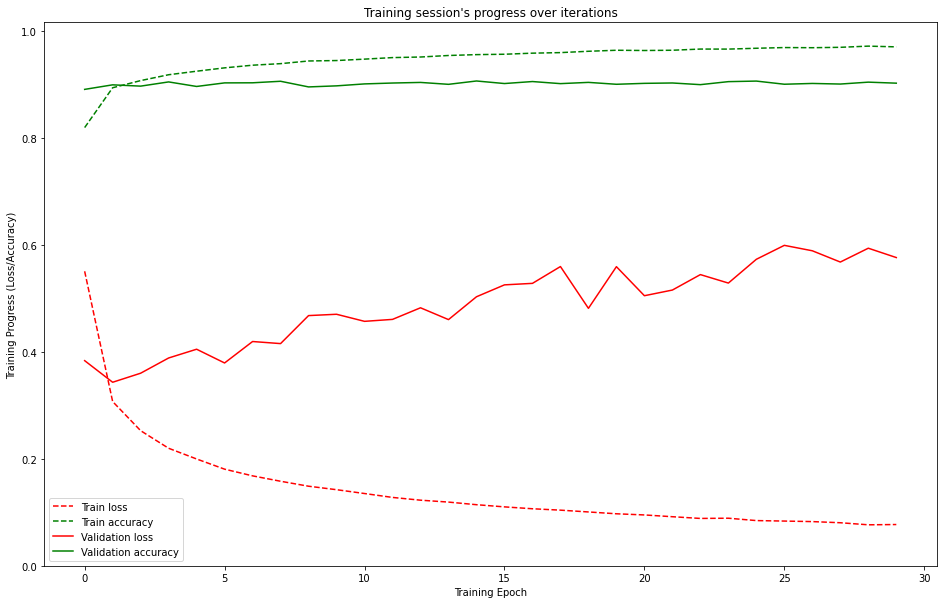

In [ ]:
## OLD

plt.figure(figsize=(16,10))
plt.plot(np.array(convLSTM_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(convLSTM_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(convLSTM_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(convLSTM_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

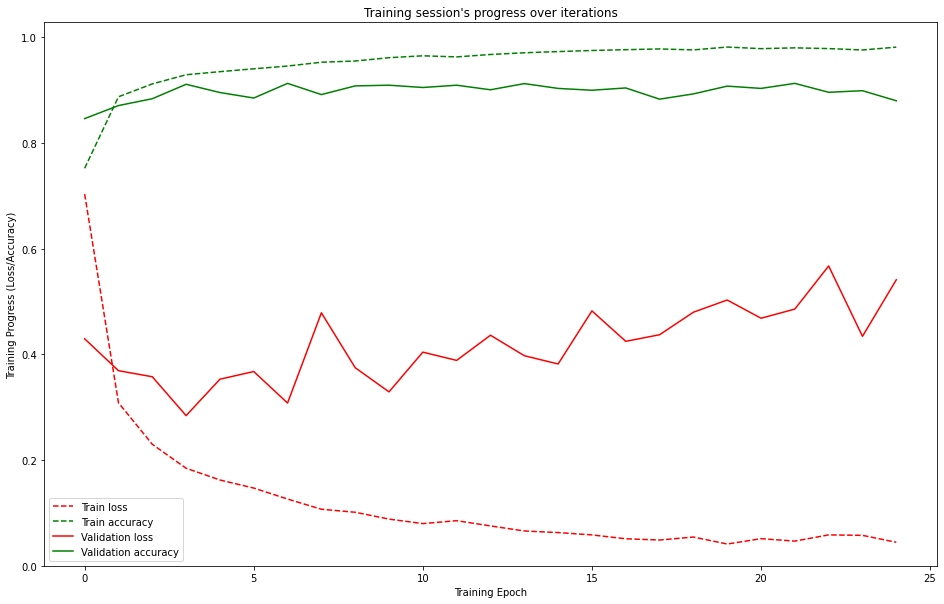

In [ ]:
## NEW

plt.figure(figsize=(16,10))
plt.plot(np.array(convLSTM_results.history['loss']),"r--",label="Train loss")
plt.plot(np.array(convLSTM_results.history['accuracy']),"g--",label="Train accuracy")
plt.plot(np.array(convLSTM_results.history['val_loss']),"r-",label="Validation loss")
plt.plot(np.array(convLSTM_results.history['val_accuracy']),"g-",label="Validation accuracy")
plt.title("Training session's progress over iterations")
plt.legend(loc='lower left')
plt.ylabel('Training Progress (Loss/Accuracy)')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.show()

In [ ]:
## OLD

loss,accuracy,precision,recall,AUC = convLSTM.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Precision :",precision)
print("Test Recall :",recall)
print("Test Loss :",loss)
print("Test AUC-ROC: ",AUC)

75/75 [==============================] - 34s 454ms/step - loss: 0.5640 - accuracy: 0.8848 - precision_1: 0.8877 - recall_1: 0.8824 - auc_1: 0.9786
Test Accuracy : 0.8847615122795105
Test Precision : 0.8876857757568359
Test Recall : 0.8824398517608643
Test Loss : 0.5640245676040649
Test AUC-ROC:  0.9785721898078918


In [ ]:
## NEW

loss,accuracy = convLSTM.evaluate(newtestX,
                               test_labels,
                               batch_size=batch_size,
                               verbose=1)
print("Test Accuracy :",accuracy)
print("Test Loss :",loss)

75/75 [==============================] - 6s 78ms/step - loss: 0.5110 - accuracy: 0.8900
Test Accuracy : 0.890038013458252
Test Loss : 0.5109699368476868


741/741 [==============================] - 9s 12ms/step


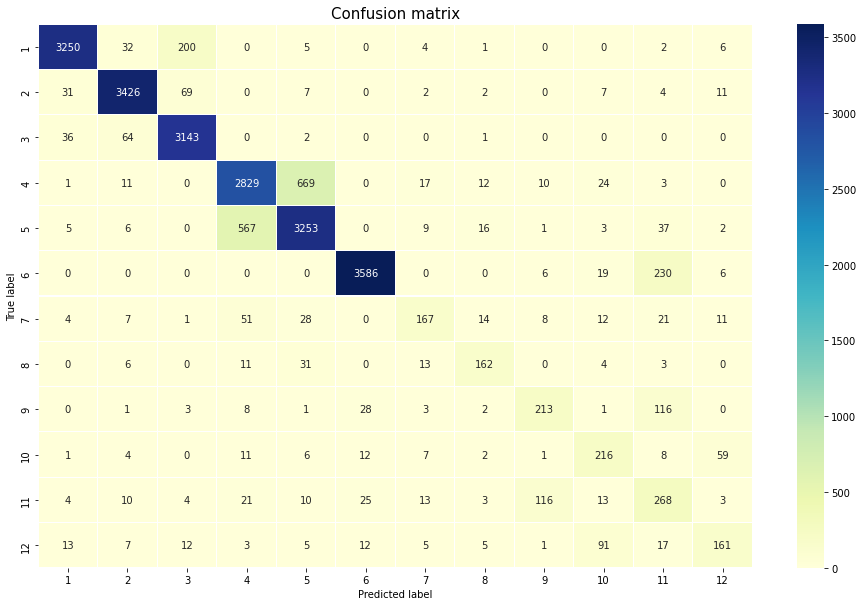

In [ ]:
## OLD

predictions = convLSTM.predict(newtestX)
class_labels = [1,2,3,4,5,6,7,8,9,10,11,12]
max_test = np.argmax(test_labels,axis=1)
max_predictions = np.argmax(predictions,axis=1)
conf_matrix = confusion_matrix(max_test,max_predictions)
plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix,
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot=True,
            linewidths=0.1,
            fmt='d',
            cmap='YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

149/149 [==============================] - 7s 44ms/step


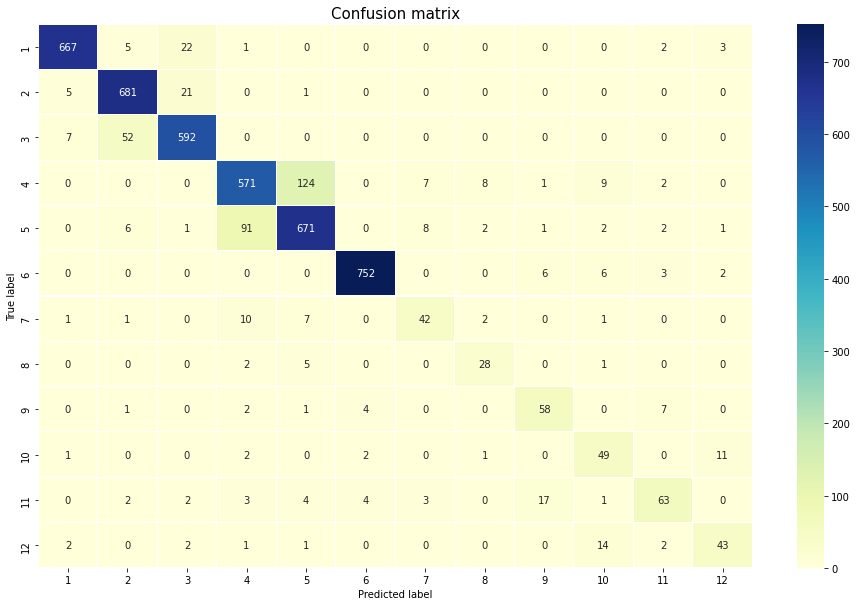

In [ ]:
## NEW

predictions = convLSTM.predict(newtestX)
class_labels = [1,2,3,4,5,6,7,8,9,10,11,12]
max_test = np.argmax(test_labels,axis=1)
max_predictions = np.argmax(predictions,axis=1)
conf_matrix = confusion_matrix(max_test,max_predictions)
plt.figure(figsize=(16,10))
sns.heatmap(conf_matrix,
            xticklabels=class_labels,
            yticklabels=class_labels,
            annot=True,
            linewidths=0.1,
            fmt='d',
            cmap='YlGnBu')
plt.title("Confusion matrix", fontsize = 15)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()